# データ解析特論 2022年度水曜２限

# 第7回 その1 Ridge 正則化

In [1]:
# import
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from ipywidgets import interact

## 正則化とは

多項式回帰において，多項式の次数を十分上げると学習誤差を限りなく下げられることを見た．しかしこの場合は汎化誤差が大きくなる過学習を引き起こす可能性があるのであった．過学習を抑えるためには汎化誤差が上がらないような次数をテスト用のデータを用いて検証すれば良いが，学習時に過学習させないように工夫することも重要である．その一つが__正則化__と呼ばれる操作である．

最小二乗法による学習では

$$
E(a_0, a_1, \ldots, a_N) := \frac1N \sum_{i=1}^N (e^{(i)})^2 = \frac1N \sum_{i=1}^N \left( y^{(i)} - a_0 - \sum_{j=1}^M a_j x_j^{(i)} \right)^2
$$

という平均二乗誤差を最小にするパラメータ $a_0, a_1, \ldots, a_M$ を求めたのであった．

正則化最小二乗法とは，ハイパーパラメータ $\eta>0$ に対して

$$
\tilde E(a_0, a_1, \ldots, a_N; \eta) := \frac1N \sum_{i=1}^N (e^{(i)})^2 + \eta \sum_{j=0}^M (a_j)^2
= \frac1N \sum_{i=1}^N \left( y^{(i)} - a_0 - \sum_{j=1}^M a_j x_j^{(i)} \right)^2 + \eta \sum_{j=0}^M (a_j)^2
\qquad ...(*)
$$

を最小にする $a_0, a_1, \ldots, a_M$ を求める手法である．$(*)$ の右辺第二項を正則化項と呼ぶ．

一般に過学習が行われるときは，過剰な回帰変数 $x_j$ にまで非零のパラメータ $a_j$ が与えられてしまい，結果的に

$$
\sum_{j=0}^M (a_j)^2
$$

の値が大きくなっている．誤差を最小化させたくても $\sum_{j=0}^M (a_j)^2$ が大きくなってしまうなら，それは最小化問題としては罰則として働いてしまう．そのため，$(*)$ の右辺第二項のことを罰則項とも呼ぶ．

In [21]:
# 真のパラメータ
A0 = 0.2
A1 = -1.6
A2 = 1.0
A3 = 3.0

# training data
X1 = np.arange(-2, 1, 0.1)
Y1 = A0 + A1*X1 + A2*X1**2 + A3*X1**3 + 4*(np.random.rand(X1.size) -0.5)

# test data
X2 = np.arange(-2.05, 1, 0.1)
Y2 = A0 + A1*X2 + A2*X2**2 + A3*X2**3 + 4*(np.random.rand(X2.size) -0.5)

X1.size, X2.size

(30, 31)

### 多項式フィッティング（復習）

回帰変数2つの重回帰では，データ空間 $(x_1, x_2, y)$ の3次元空間に回帰平面を引き，データから平面までの高さの二乗和が最小になるように選ぶ．

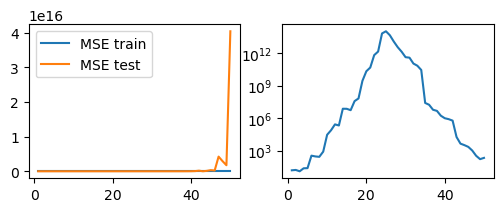

In [22]:
# フィッティングに用いる多項式の最大次数を１から1つずつ maxM まで増やしていく
maxM = 50

# dataset: Xtrain, Xtest
Xtrain = np.ones((X1.size, 1))
Xtest  = np.ones((X2.size, 1))

# 回帰モデルの設定: reg
reg = LinearRegression(fit_intercept=False)

# MSE格納用配列: MSE1 and MSE2
MSE1 = np.zeros(maxM+1)
MSE2 = np.zeros(maxM+1)

# 回帰係数格納用配列: coeff
coeff = np.zeros((maxM+1, maxM+1))

# 回帰係数のL^2ノルム用配列: anorm2
anorm2 = np.zeros(maxM+1)

# 多項式の次数 M ごとに MSE と回帰係数とそのノルムを計算
for M in range(1, maxM+1):
    # 多項式回帰用の回帰変数の配列を作成
    Xtrain = np.hstack([Xtrain, X1.reshape(-1, 1)**M])
    Xtest  = np.hstack([Xtest,  X2.reshape(-1, 1)**M])
    
    # 学習データとテストデータの予測値を出力
    Y1pred = reg.fit(Xtrain, Y1).predict(Xtrain)
    Y2pred = reg.predict(Xtest)
    
    # 回帰係数の格納
    coeff[M, :M+1] = reg.coef_
    
    # MSE の計算
    MSE1[M] = np.mean((Y1-Y1pred)**2)
    MSE2[M] = np.mean((Y2-Y2pred)**2)
    
    # 回帰係数のL^2ノルム
    anorm2[M] = np.sum(reg.coef_**2)
    
### 結果の描画 ###
# MSE
fig, ax = plt.subplots(ncols=2, figsize=(6, 2))
ax[0].plot(np.arange(1, maxM+1), MSE1[1:], label='MSE train')
ax[0].plot(np.arange(1, maxM+1), MSE2[1:], label='MSE test')
ax[0].legend()

# 回帰係数のL^2ノルム
ax[1].plot(np.arange(1, maxM+1), anorm2[1:])
ax[1].set_yscale('log')


多項式の次数が増えるにつれ，テスト誤差が大きくなるし，さらに学習で得た回帰係数の $L^2$ ノルムが異常に大きくなっている．右図の縦軸は対数であることに注意する．  
（この例でも double descent は観察されるので，サンプルサイズより大きな次数を取るとテスト誤差や回帰係数のノルムは下がっている．）

In [25]:
# 多項式回帰関数のプロット
def plot_XY_and_PolyReg(M=1):
    # 回帰多項式の曲線 XX, YY
    XX = np.arange(-2, 1, 0.01)
    
    #YY = coeff[M, 0]
    #for i in range(1, M+1):
    #    YY += coeff[M, i]*XX**i
    YY = np.sum(coeff[M] * XX.reshape(-1, 1)**np.arange(maxM+1), axis=1)
    
    # 描画
    fig, ax = plt.subplots(ncols=2, figsize=(6, 2))
    
    # train
    ax[0].scatter(X1, Y1)
    ax[0].plot(XX, YY, c='tab:orange', zorder=1)
    ax[0].set_ylim(-20, 5)
    ax[0].set_title('MSE = %f'%(MSE1[M]))
    # test
    ax[1].scatter(X2, Y2)
    ax[1].plot(XX, YY, c='tab:orange', zorder=1)
    ax[1].set_ylim(-20, 5)
    ax[1].set_title('MSE = %f'%(MSE2[M]))

In [26]:
# interact で M を変えてみる
interact(plot_XY_and_PolyReg, M=(1, maxM))

interactive(children=(IntSlider(value=1, description='M', max=50, min=1), Output()), _dom_classes=('widget-int…

<function __main__.plot_XY_and_PolyReg(M=1)>

やはり次数を上げると学習で得られた回帰多項式は大きく振動することがわかる．汎化性能が低いのはそれが理由である．

## 正則化する！

上では正則化せずに多項式フィッティングを行ったので過学習が起きやすく汎化誤差が大きくなる傾向が見られた．

以下では正則化項を入れて多項式フィッティングを行うことにして，正則化の影響を確認しよう．

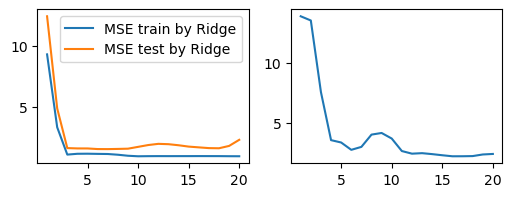

In [44]:
# 正則化パラメータ
alpha = 1.1

# フィッティングに用いる多項式の最大次数を１から1つずつ maxM まで増やしていく
maxM = 20

# dataset: Xtrain, Xtest
XtrainR = np.ones((X1.size, 1))
XtestR  = np.ones((X2.size, 1))

# 回帰モデルの設定: reg
regR = Ridge(alpha=alpha, fit_intercept=False)

# MSE格納用配列: MSE1 and MSE2
MSE1R = np.zeros(maxM+1)
MSE2R = np.zeros(maxM+1)

# 回帰係数格納用配列: coeff
coeffR = np.zeros((maxM+1, maxM+1))

# 回帰係数のL^2ノルム用配列: anorm2
anorm2R = np.zeros(maxM+1)

# 多項式の次数 M ごとに MSE と回帰係数とそのノルムを計算
for M in range(1, maxM+1):
    # 多項式回帰用の回帰変数の配列を作成
    XtrainR = np.hstack([XtrainR, X1.reshape(-1, 1)**M])
    XtestR  = np.hstack([XtestR,  X2.reshape(-1, 1)**M])
    
    # 学習データとテストデータの予測値を出力
    Y1predR = regR.fit(XtrainR, Y1).predict(XtrainR)
    Y2predR = regR.predict(XtestR)
    
    # 回帰係数の格納
    coeffR[M, :M+1] = regR.coef_
    
    # MSE の計算
    MSE1R[M] = np.mean((Y1-Y1predR)**2)
    MSE2R[M] = np.mean((Y2-Y2predR)**2)
    
    # 回帰係数のL^2ノルム
    anorm2R[M] = np.sum(regR.coef_**2)
    
### 結果の描画 ###
# MSE
fig, ax = plt.subplots(ncols=2, figsize=(6, 2))
ax[0].plot(np.arange(1, maxM+1), MSE1R[1:], label='MSE train by Ridge')
ax[0].plot(np.arange(1, maxM+1), MSE2R[1:], label='MSE test by Ridge')
ax[0].legend()

# 回帰係数のL^2ノルム
ax[1].plot(np.arange(1, maxM+1), anorm2R[1:])
#ax[1].set_yscale('log')


In [45]:
# 多項式回帰関数のプロット
def plot_XY_and_PolyRegRidge(M=1):
    XX = np.arange(-2, 1, 0.01)
    YY = np.sum(coeffR[M] * XX.reshape(-1, 1)**np.arange(maxM+1), axis=1)
    
    # 描画
    fig, ax = plt.subplots(ncols=2, figsize=(6, 2))
    
    # train
    ax[0].scatter(X1, Y1)
    ax[0].plot(XX, YY, c='tab:orange', zorder=1)
    ax[0].set_ylim(-20, 5)
    ax[0].set_title('MSE = %f'%(MSE1R[M]))
    # test
    ax[1].scatter(X2, Y2)
    ax[1].plot(XX, YY, c='tab:orange', zorder=1)
    ax[1].set_ylim(-20, 5)
    ax[1].set_title('MSE = %f'%(MSE2R[M]))

In [43]:
# interact で M を変えてみる
interact(plot_XY_and_PolyRegRidge, M=(1, maxM))

interactive(children=(IntSlider(value=1, description='M', max=20, min=1), Output()), _dom_classes=('widget-int…

<function __main__.plot_XY_and_PolyRegRidge(M=1)>

## 演習 07-1

Iris データセットに対して，Ridge 正則化によるフィッティングと AIC によるモデル選択（正則化は行わない）ではどのような差が起きるか． 
データを解析して両者を比較し，考察せよ．

<h3><div style="text-align: right;">以上</div></h3>